-----
<center>
<h1 style="font-size: 50px; font-family: serif;">Image based plant disease detection
</h1>
</center>

---

---
# 1. Import Modules 
<span id="Importmodules"></span>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import tensorflow as tf
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load and preprocess the dataset
train_dir = 'train'
test_dir = 'test'

In [3]:
# ImageDataGenerator for loading and augmenting images
datagen = ImageDataGenerator(rescale=1./255)

---
# 2. Load images with augmentation
<span id="Importmodules"></span>

---

In [4]:
# Load images from the training directory
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Load images from the testing directory
test_data_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Step 1: Load MobileNet as a feature extractor
base_model = MobileNet(weights='imagenet', include_top=False)

# Add a Global Average Pooling layer to extract features
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of MobileNet to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Step 2: Extract features for training and testing data
def extract_features(data_generator):
    features = []
    labels = []
    
    # Loop through batches of images and extract features
    for images, batch_labels in data_generator:
        # Extract features from the MobileNet model
        feature_batch = feature_extractor.predict(images)
        features.append(feature_batch)
        labels.append(batch_labels)
        
        # If we have enough data, stop
        if len(features) * data_generator.batch_size >= data_generator.samples:
            break
    
    # Convert to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features for train data
X_train_features, y_train_labels = extract_features(train_data_gen)

# Extract features for test data
X_test_features, y_test_labels = extract_features(test_data_gen)

# Step 3: Save the extracted features to .joblib files
joblib.dump((X_train_features, y_train_labels), 'train.joblib')
joblib.dump((X_test_features, y_test_labels), 'test.joblib')

# Step 4: Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_features, y_train_labels, test_size=0.2, random_state=42
)

# Optionally, save the split data to .joblib files
joblib.dump((X_train, y_train), 'train_split.joblib')
joblib.dump((X_val, y_val), 'val_split.joblib')

# Saved in 'train.joblib' and 'test.joblib'
print("Features extracted and saved to 'train.joblib' and 'test.joblib'.")

Found 6997 images belonging to 51 classes.
Found 1767 images belonging to 51 classes.


1/1 [==============================] - 0s 166ms/step
Features extracted and saved to 'train.joblib' and 'test.joblib'.


---
# 3. Mobilenet Model
<span id="Importmodules"></span>

---

In [5]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input


# Load the features extracted previously
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# If the labels are not already one-hot encoded, we can one-hot encode them
num_classes = y_train_labels.shape[1]  

input_shape = X_train_features.shape[1]  # The number of features per sample (1024 in this case)

# Define the model for classification
input_layer = Input(shape=(input_shape,))  # This is the shape of the features (1024,)
x = Dropout(0.5)(input_layer)  # Dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)  # Another Dropout layer
output_layer = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val))


Epoch 1/50


175/175 [==============================] - 6s 24ms/step - loss: 1.9533 - accuracy: 0.4860 - val_loss: 0.5824 - val_accuracy: 0.8343
Epoch 2/50
175/175 [==============================] - 4s 25ms/step - loss: 0.8442 - accuracy: 0.7390 - val_loss: 0.4783 - val_accuracy: 0.8450
Epoch 3/50
175/175 [==============================] - 4s 24ms/step - loss: 0.6715 - accuracy: 0.7835 - val_loss: 0.4483 - val_accuracy: 0.8607
Epoch 4/50
175/175 [==============================] - 4s 25ms/step - loss: 0.5924 - accuracy: 0.8110 - val_loss: 0.3829 - val_accuracy: 0.8700
Epoch 5/50
175/175 [==============================] - 4s 23ms/step - loss: 0.5325 - accuracy: 0.8296 - val_loss: 0.3279 - val_accuracy: 0.8871
Epoch 6/50
175/175 [==============================] - 4s 24ms/step - loss: 0.5020 - accuracy: 0.8333 - val_loss: 0.3704 - val_accuracy: 0.8714
Epoch 7/50
175/175 [==============================] - 4s 25ms/step - loss: 0.4489 - accuracy: 0.8512 - val_loss: 0.3115 - val_accuracy: 0.88

In [6]:
# Save the trained model
model.save('mobilenet_v2_classifier_model.h5')

---
# 4. Plot training and validation accuracy
<span id="Importmodules"></span>

---

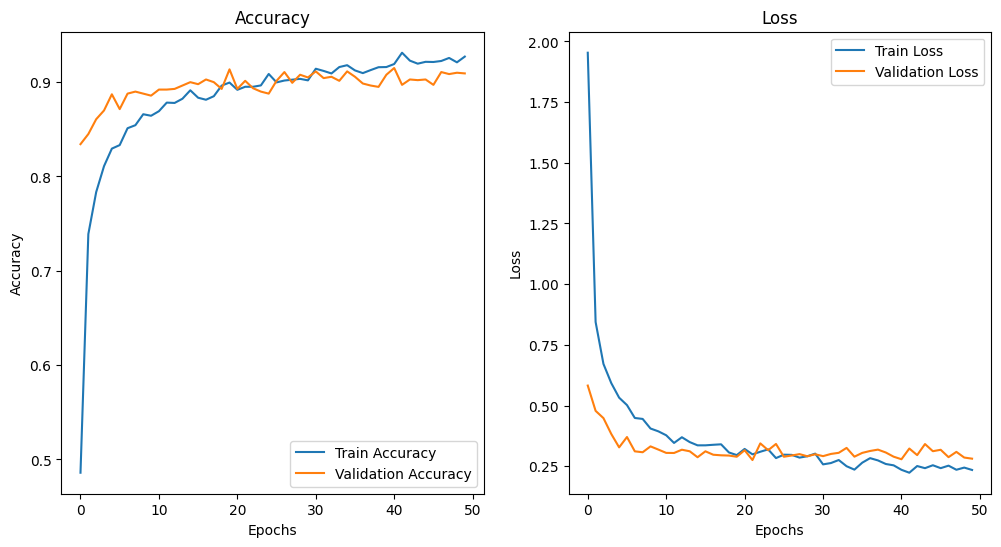

In [7]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

56/56 [==============================] - 0s 3ms/step - loss: 0.2280 - accuracy: 0.9281
Test accuracy: 0.9281
Test loss: 0.2280
56/56 [==============================] - 0s 2ms/step


---
# 5. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

Confusion Matrix:
[[37  0  2 ...  0  0  0]
 [ 0 39  0 ...  0  0  0]
 [ 0  0 40 ...  0  0  0]
 ...
 [ 0  0  0 ... 40  0  0]
 [ 0  0  0 ...  0 46  0]
 [ 0  0  0 ...  0  0 32]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        40
           1       0.97      0.97      0.97        40
           2       0.83      1.00      0.91        40
           3       0.98      1.00      0.99        40
           4       1.00      1.00      1.00        40
           5       0.98      1.00      0.99        40
           6       1.00      0.97      0.99        40
           7       1.00      0.95      0.97        40
           8       1.00      1.00      1.00        40
           9       1.00      1.00      1.00        40
          10       1.00      0.97      0.99        40
          11       0.93      0.95      0.94        40
          12       0.33      0.17      0.22        12
          13       0.30      0.50      0.38   

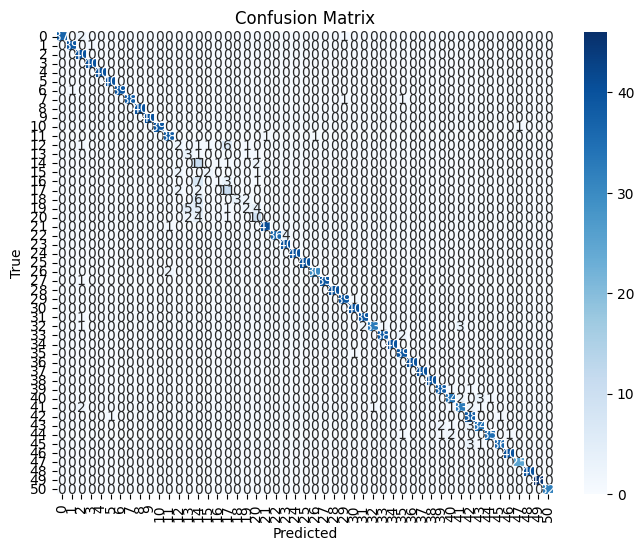

In [9]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# 6. CNN Model
<span id="Importmodules"></span>

---

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load the features and labels for train, validation, and test sets
X_train_features, y_train_labels = joblib.load('train_split.joblib')
X_val, y_val = joblib.load('val_split.joblib')
X_test_features, y_test_labels = joblib.load('test.joblib')

# Print the shape of the features to confirm
print(f"X_train_features shape: {X_train_features.shape}")
print(f"y_train_labels shape: {y_train_labels.shape}")
print(f"X_test_features shape: {X_test_features.shape}")
print(f"y_test_labels shape: {y_test_labels.shape}")

# Define the fully connected model for the extracted features
model = Sequential()

# Input layer (feature vectors of size 1024)
model.add(Dense(1024, activation='relu', input_shape=(X_train_features.shape[1],)))
model.add(Dropout(0.5))  # Dropout to reduce overfitting

# Hidden layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer (number of classes)
model.add(Dense(y_train_labels.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train_labels, 
                    epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val))

X_train_features shape: (5597, 1024)
y_train_labels shape: (5597, 51)
X_test_features shape: (1767, 1024)
y_test_labels shape: (1767, 51)
Epoch 1/50
175/175 [==============================] - 7s 33ms/step - loss: 3.3485 - accuracy: 0.1478 - val_loss: 1.8299 - val_accuracy: 0.5836
Epoch 2/50
175/175 [==============================] - 6s 32ms/step - loss: 1.7512 - accuracy: 0.4781 - val_loss: 0.8968 - val_accuracy: 0.7379
Epoch 3/50
175/175 [==============================] - 5s 31ms/step - loss: 1.1718 - accuracy: 0.6273 - val_loss: 0.6412 - val_accuracy: 0.7893
Epoch 4/50
175/175 [==============================] - 5s 31ms/step - loss: 0.9000 - accuracy: 0.7106 - val_loss: 0.5478 - val_accuracy: 0.8043
Epoch 5/50
175/175 [==============================] - 6s 32ms/step - loss: 0.7626 - accuracy: 0.7574 - val_loss: 0.4583 - val_accuracy: 0.8521
Epoch 6/50
175/175 [==============================] - 6s 33ms/step - loss: 0.6824 - accuracy: 0.7838 - val_loss: 0.4455 - val_accuracy: 0.8550
Epoc

In [11]:
# Save the model
model.save('cnn_model.h5')

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_features, y_test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

56/56 [==============================] - 0s 4ms/step - loss: 0.2710 - accuracy: 0.9276
Test accuracy: 0.9276
Test loss: 0.2710


---
# 11. Plot training and validation accuracy
<span id="Importmodules"></span>

---

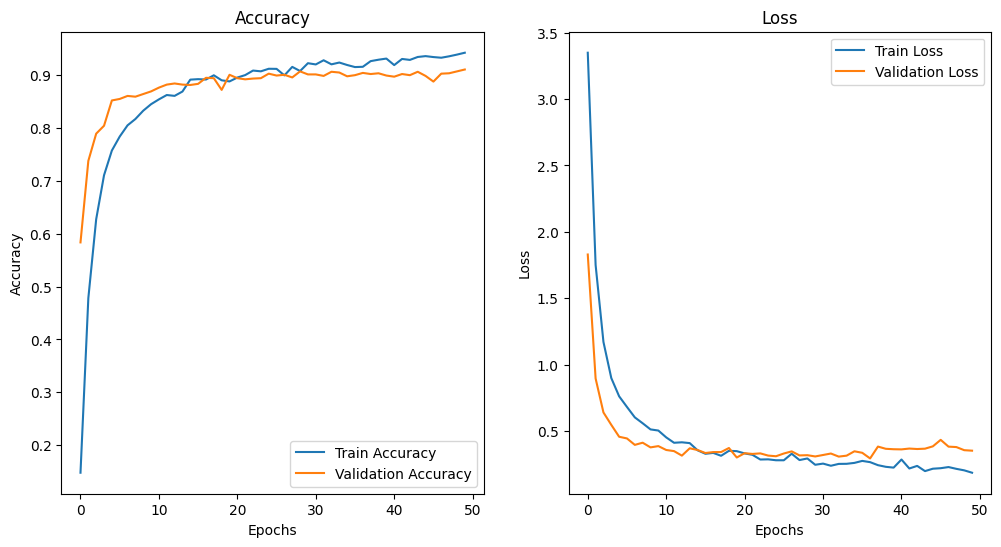

In [13]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
# 12. Confusion Matrix and Classification Report
<span id="Importmodules"></span>

---

56/56 [==============================] - 0s 4ms/step
Confusion Matrix:
[[36  0  2 ...  0  0  0]
 [ 0 37  0 ...  0  0  0]
 [ 0  0 40 ...  0  0  0]
 ...
 [ 0  0  0 ... 40  0  0]
 [ 0  0  0 ...  0 46  0]
 [ 0  0  0 ...  0  0 32]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       1.00      0.93      0.96        40
           2       0.95      1.00      0.98        40
           3       0.95      1.00      0.98        40
           4       1.00      1.00      1.00        40
           5       0.93      1.00      0.96        40
           6       0.98      1.00      0.99        40
           7       0.95      1.00      0.98        40
           8       1.00      0.97      0.99        40
           9       1.00      1.00      1.00        40
          10       0.98      1.00      0.99        40
          11       0.95      1.00      0.98        40
          12       0.67      0.33      0.44    

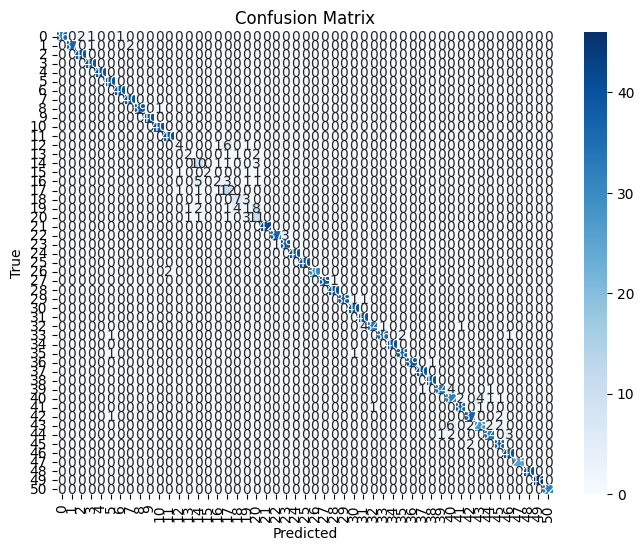

In [14]:
# Make predictions on the test set
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_labels, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
# Extract class names from the training data generator
class_indices = train_data_gen.class_indices  # This gives a dictionary mapping class names to indices
class_names = [key for key, _ in sorted(class_indices.items(), key=lambda item: item[1])]

print("Class Names:", class_names)


Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Downy mildew', 'Eggplant - Epilachna Beetle', 'Eggplant - Flea Beetle', 'Eggplant - Healthy', 'Eggplant - Jassid', 'Eggplant - Mite', 'Eggplant - Mite and Epilachna Beetle', 'Eggplant - Nitrogen Deficiency', 'Eggplant - Nitrogen and Potassium Deficiency', 'Eggplant - Potassium Deficiency', 'Fresh Leaf', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Gray mold', 'Leaf scars', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot'